In [1]:
import pandas as pd

In [2]:
labels = pd.read_csv('../input/dog-breed-identification/labels.csv')

In [3]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
breed_count = labels['breed'].value_counts()
breed_count

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [5]:
import numpy as np
targets = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets, sparse=True)
ont_hot_labels = np.asarray(one_hot)

In [6]:
img_rows, img_cols = 128, 128
num_channel = 3


In [7]:
import matplotlib.pyplot as plt
import cv2

In [9]:
from tqdm import tqdm

x_feature = []
y_feature = []

i = 0
for f, img in tqdm(labels.values):
    train_img = cv2.imread('../input/dog-breed-identification/train/{}.jpg'.format(f), 0)
    label = ont_hot_labels[i]
    train_img_resized = cv2.resize(train_img, (img_rows, img_cols))
    x_feature.append(train_img_resized)
    y_feature.append(label)

100%|██████████| 10222/10222 [00:45<00:00, 222.91it/s]


In [10]:
x_train_data = np.array(x_feature, np.float32) / 255.
x_train_data = np.expand_dims(x_train_data, axis=3)

x_train_data.shape

(10222, 128, 128, 1)

In [11]:
y_train_data = np.array(y_feature, np.uint8)
y_train_data.shape

(10222, 120)

In [12]:
from sklearn.model_selection import train_test_split

# train_test_split train, valid
x_train, x_val, y_train, y_val = train_test_split(x_train_data, y_train_data, test_size=0.2)

In [13]:
submission = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')


In [14]:
test_img = submission['id']

In [15]:
x_test_feature = []

i = 0
for f in tqdm(test_img.values):
    img = cv2.imread('../input/dog-breed-identification/test/{}.jpg'.format(f), 0)
    img_resize = cv2.resize(img, (img_rows, img_cols))
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:46<00:00, 222.92it/s]


In [16]:
x_test_data = np.array(x_test_feature, np.float32) / 255.
x_test_data = np.expand_dims(x_test_data, axis = 3)

In [34]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

# input_shape = (이미지 가로 , 이미지 세로,  chaneel)

model = Sequential([
    Conv2D(64, kernel_size=(4, 4), padding='Same', activation='relu', input_shape=(img_rows, img_cols, 1)),
    MaxPooling2D(2),
    Conv2D(64, kernel_size=(4, 4), padding='Same', activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(120, activation='softmax')
])

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
x_train.shape, y_train.shape

((8177, 128, 128, 1), (8177, 120))

In [37]:
x_test_data.shape

(10357, 128, 128, 1)

In [38]:
# fit validation_data 직접 

history = model.fit(x_train, y_train, batch_size = 128, epochs=2, validation_data=(x_val, y_val))

Epoch 1/2
64/64 [==============================] - 4s 67ms/step - loss: 0.0897 - accuracy: 0.9843 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
64/64 [==============================] - 4s 62ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


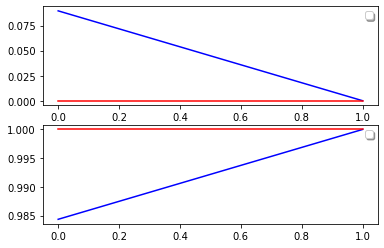

In [41]:
loss, val_loss = history.history['loss'], history.history['val_loss']
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

fig, ax = plt.subplots(2, 1)

ax[0].plot(loss, 'b')
ax[0].plot(val_loss, 'r')
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(acc, 'b')
ax[1].plot(val_acc, 'r')
legend = ax[1].legend(loc='best', shadow=True)

In [42]:
results = model.predict(x_test_data)
prediction = pd.DataFrame(results)

In [46]:
cole_names = one_hot.columns.values
prediction.columns = cole_names

In [ ]:
prediction.insert(0, 'id', submission['id'])

submission = prediction
submission.to_csv('submission.csv', index=False)